# Week 1: Working with time series

Welcome! In this assignment you will be working with time series data. All of the data is going to be generated and you will implement several functions to split the data, create forecasts and evaluate the quality of those forecasts.


Let's get started!

_**NOTE:** To prevent errors from the autograder, you are not allowed to edit or delete non-graded cells in this notebook . Please only put your solutions in between the `### START CODE HERE` and `### END CODE HERE` code comments, and also refrain from adding any new cells. **Once you have passed this assignment** and want to experiment with any of the non-graded code, you may follow the instructions at the bottom of this notebook._

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

The next cell includes a bunch of helper functions to generate and plot the time series:

In [ ]:
def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def plot_series(time, series, format="-", title="", label=None, start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    if label:
        plt.legend()
    plt.grid(True)

### Generate time series data

Using the previous functions, generate data that resembles a real-life time series.

Notice that `TIME` represents the values in the x-coordinate while `SERIES` represents the values in the y-coordinate. This naming is used to avoid confusion with other kinds of data in which `x` and `y` have different meanings.

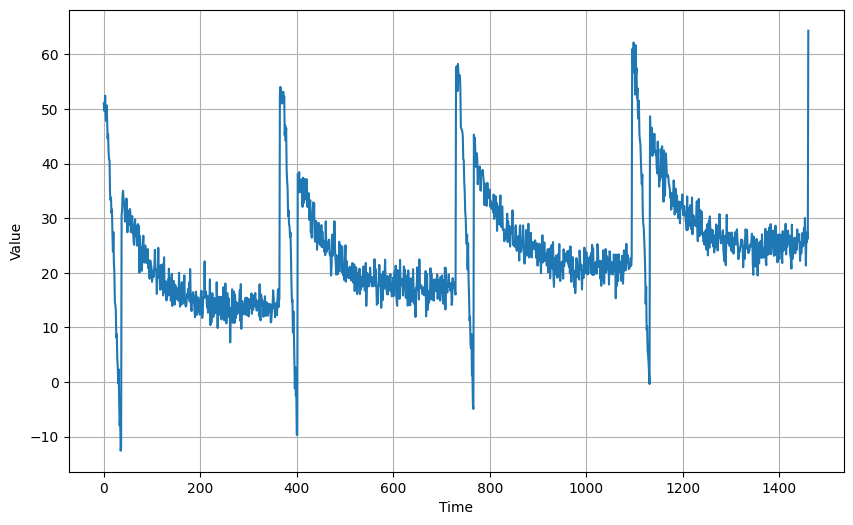

In [ ]:
# The time dimension or the x-coordinate of the time series
TIME = np.arange(4 * 365 + 1, dtype="float32")

# Initial series is just a straight line with a y-intercept
y_intercept = 10
slope = 0.01
SERIES = trend(TIME, slope) + y_intercept

# Adding seasonality
amplitude = 40
SERIES += seasonality(TIME, period=365, amplitude=amplitude)

# Adding some noise
noise_level = 2
SERIES += noise(TIME, noise_level, seed=42)

# Plot the series
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

Now that we have the time series, let's split it so we can start forecasting.

Complete the `train_val_split` function below which receives the `time` (x coordinate) and `series` (y coordinate) data along with the `time_step` in which to perform the split. Notice that this value defaults to 1100 since this is an appropiate step to split the series into training and validation:

In [ ]:
# Define time step to split the series
SPLIT_TIME = 1100

# GRADED FUNCTION: train_val_split
def train_val_split(time, series, time_step=SPLIT_TIME):

    ### START CODE HERE
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]
    ### END CODE HERE

    return time_train, series_train, time_valid, series_valid

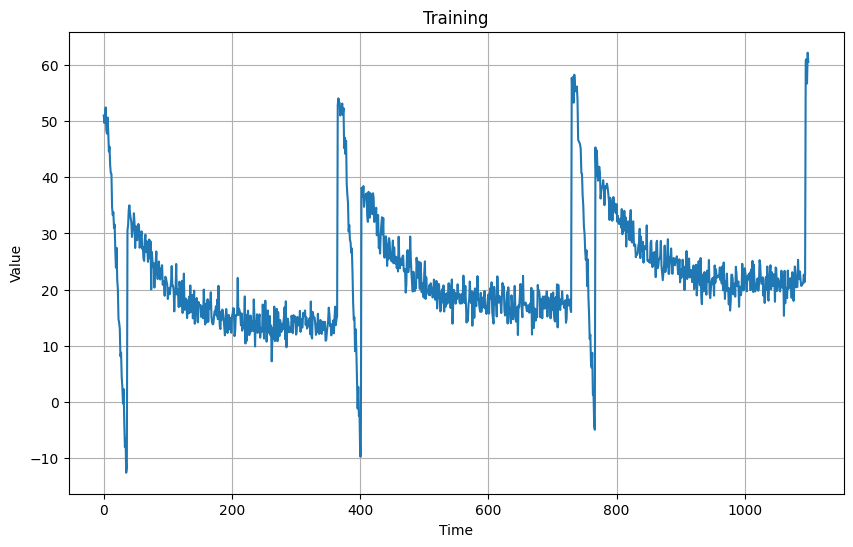

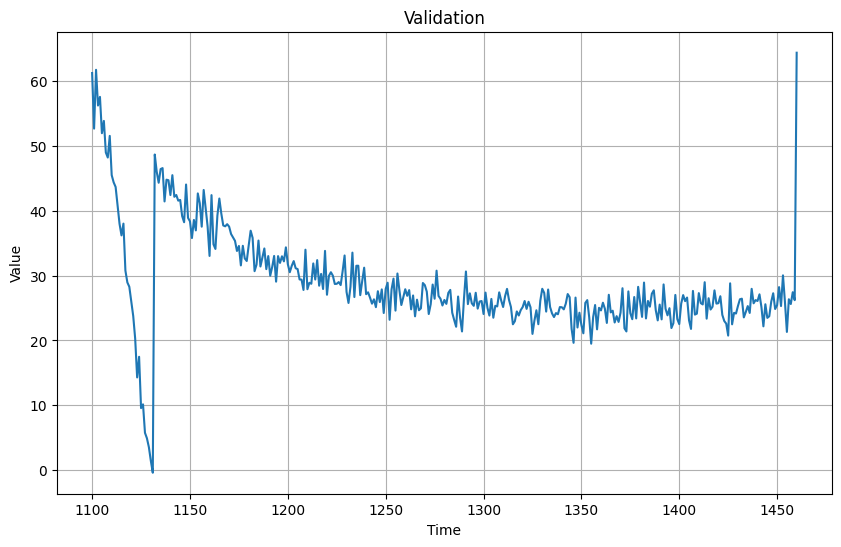

In [ ]:
# Test your function
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

plt.figure(figsize=(10, 6))
plot_series(time_train, series_train, title="Training")
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, title="Validation")
plt.show()

**Expected Output:**

<table><tr><td><img src='images/train_series.png'></td><td><img src='images/val_series.png'></td></tr></table>

### Evaluation Metrics

Now that you have successfully splitted the data into training and validation sets you will need a way of knowing how good your forecasts are. For this complete the `compute_metrics` below. This function receives the true series and the forecast and returns the `mse` and the `mae` between the two curves. These metrics should be numpy numeric types.

**Notice that this function does not receive any time (x coordinate) data since it assumes that both series will have the same values for the x coordinate.**

In [ ]:
# GRADED FUNCTION: compute_metrics
def compute_metrics(true_series, forecast):

    ### START CODE HERE
    mse = keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    ### END CODE HERE

    return mse, mae

In [ ]:
# Test your function

# Define some dummy series for testing
zeros = np.zeros(5)
ones = np.ones(5)

mse, mae = compute_metrics(zeros, ones)
print(f"mse: {mse}, mae: {mae} for series of zeros and prediction of ones\n")

mse, mae = compute_metrics(ones, ones)
print(f"mse: {mse}, mae: {mae} for series of ones and prediction of ones\n")

print(f"metrics are numpy numeric types: {np.issubdtype(type(mse), np.number)}")

mse: 1.0, mae: 1.0 for series of zeros and prediction of ones

mse: 0.0, mae: 0.0 for series of ones and prediction of ones

metrics are numpy numeric types: True


**Expected Output:**

```
mse: 1.0, mae: 1.0 for series of zeros and prediction of ones

mse: 0.0, mae: 0.0 for series of ones and prediction of ones

metrics are numpy numeric types: True
```

## Forecasting

Now that you have a way of measuring the performance of your forecasts it is time to actually start doing some forecasts.

Let's start easy by using a naive forecast.

## Naive Forecast

Define the `naive_forecast` variable below. This series should be identical to the validation one but delayed one time step. It also receives the split time step of the series for ease of computing the delayed series.

**Notice that this series should leave out the last element since this element does not exists in the validation set and you will not be able to compute the evaluation metrics if this element is kept.**

Hint:

- Use the whole `SERIES` (training and validation) and the `SPLIT_TIME` to compute this one.

validation series has shape: (361,)

naive forecast has shape: (361,)

comparable with validation series: True


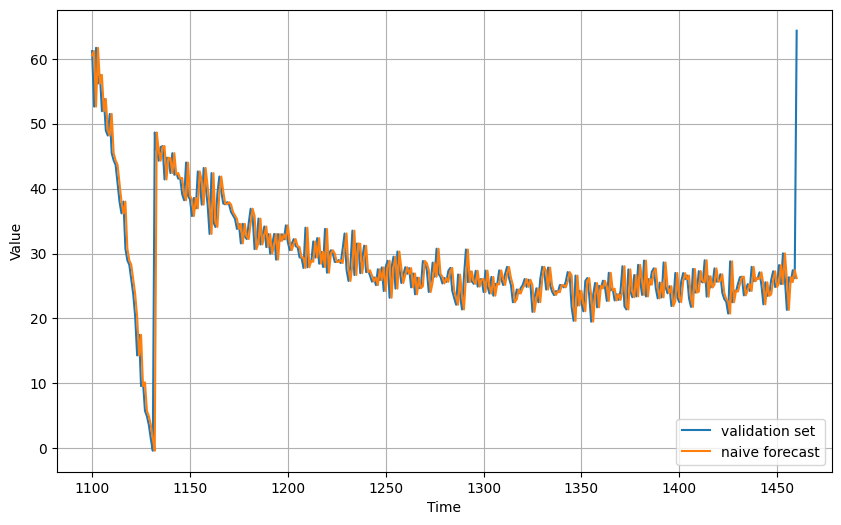

In [ ]:
### START CODE HERE
naive_forecast = SERIES[SPLIT_TIME - 1:-1]
### END CODE HERE

print(f"validation series has shape: {series_valid.shape}\n")
print(f"naive forecast has shape: {naive_forecast.shape}\n")
print(f"comparable with validation series: {series_valid.shape == naive_forecast.shape}")

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, label="validation set")
plot_series(time_valid, naive_forecast, label="naive forecast")

**Expected Output:**

```
validation series has shape: (361,)

naive forecast has shape: (361,)

comparable with validation series: True
```
<div>
<img src="images/naive.png" width="500"/>
</div>

Let's zoom in on the end of the validation period:

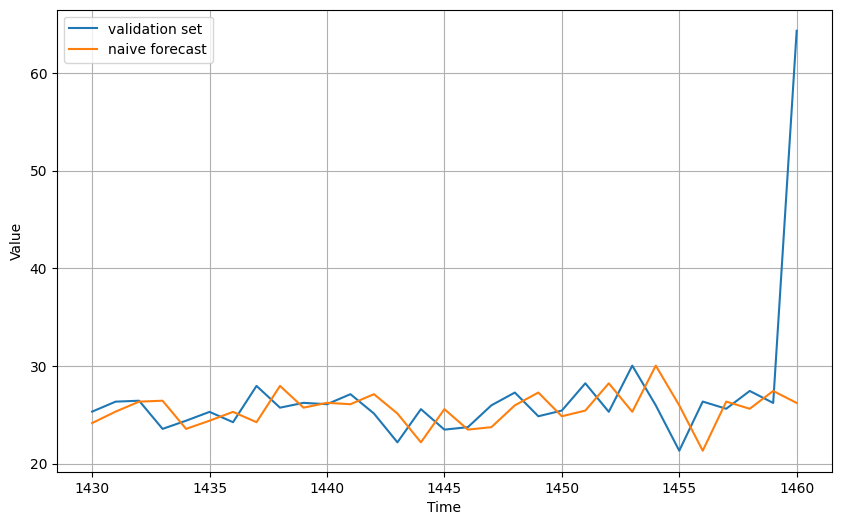

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, start=330, end=361, label="validation set")
plot_series(time_valid, naive_forecast, start=330, end=361, label="naive forecast")

**You should see that the naive forecast lags 1 step behind the time serie and that both series end on the same time step.**

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [ ]:
mse, mae = compute_metrics(series_valid, naive_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for naive forecast")

mse: 19.58, mae: 2.60 for naive forecast


That's our baseline, now let's try a moving average.

### Moving Average

Complete the `moving_average_forecast` below. This function receives a `series` and a `window_size` and computes the moving average forecast for every point after the initial `window_size` values.

**This function will receive the complete `SERIES` and the returned series will then be sliced to match the validation period so your function doesn't need to account for matching the series to the validation period.**

In [ ]:
# GRADED FUNCTION: moving_average_forecast
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
        If window_size=1, then this is equivalent to naive forecast"""

    forecast = []

    ### START CODE HERE
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())

    # Conver to a numpy array
    np_forecast = np.array(forecast)

    ### END CODE HERE

    return np_forecast

You cannot compute the moving average for the first `window_size` values since there aren't enough values to compute the desired average. So if you use the whole `SERIES` and a `window_size` of 30 your function should return a series with the number of elements equal to:

```python
len(SERIES) - 30
```

In [ ]:
print(f"Whole SERIES has {len(SERIES)} elements so the moving average forecast should have {len(SERIES)-30} elements")

Whole SERIES has 1461 elements so the moving average forecast should have 1431 elements


moving average forecast with whole SERIES has shape: (1431,)

moving average forecast after slicing has shape: (361,)

comparable with validation series: True


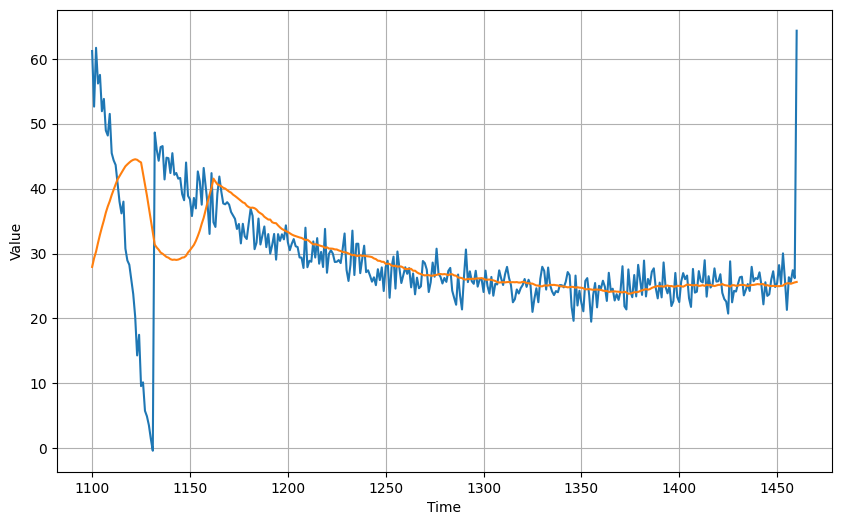

In [ ]:
# Test your function
moving_avg = moving_average_forecast(SERIES, window_size=30)
print(f"moving average forecast with whole SERIES has shape: {moving_avg.shape}\n")

# Slice it so it matches the validation period
moving_avg = moving_avg[1100 - 30:]
print(f"moving average forecast after slicing has shape: {moving_avg.shape}\n")
print(f"comparable with validation series: {series_valid.shape == moving_avg.shape}")


plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, moving_avg)

In [ ]:
# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, moving_avg)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average forecast")

mse: 65.79, mae: 4.30 for moving average forecast


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing.

### Differencing

Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

Define the `diff_series` and `diff_time` variables below to achieve this. Notice that `diff_time` is the values of the x-coordinate for `diff_series`.

Whole SERIES has 1461 elements so the differencing should have 1096 elements

diff series has shape: (1096,)

x-coordinate of diff series has shape: (1096,)



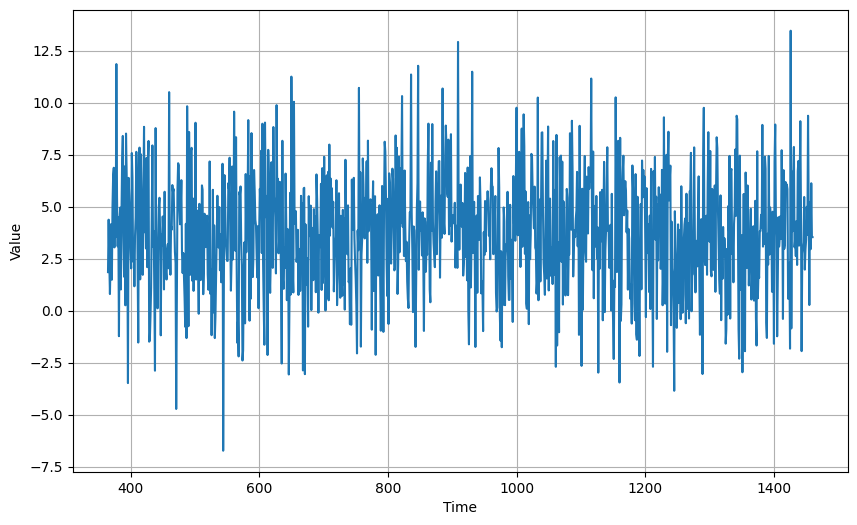

In [ ]:
### START CODE HERE
diff_series = (SERIES[365:] - SERIES[:-365])
diff_time = TIME[365:]
### END CODE HERE

print(f"Whole SERIES has {len(SERIES)} elements so the differencing should have {len(SERIES)-365} elements\n")
print(f"diff series has shape: {diff_series.shape}\n")
print(f"x-coordinate of diff series has shape: {diff_time.shape}\n")

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average.

Define the `diff_moving_avg` variable.

**Notice that the `window_size` has already being defined and that you will need to perform the correct slicing for the series to match the validation period.**

moving average forecast with diff series has shape: (1046,)

moving average forecast with diff series after slicing has shape: (361,)

comparable with validation series: True


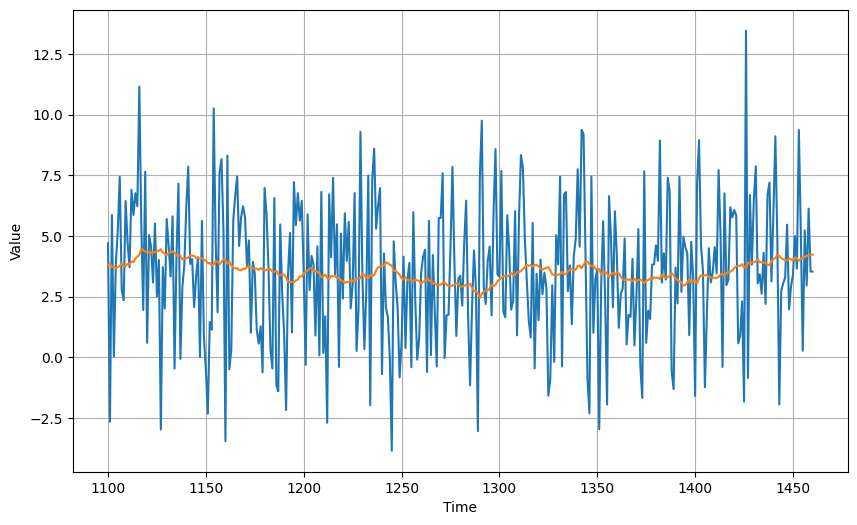

In [ ]:
### START CODE HERE

# Apply the moving avg to diff series
diff_moving_avg = moving_average_forecast(diff_series, 50)

print(f"moving average forecast with diff series has shape: {diff_moving_avg.shape}\n")

# Perform the correct slicing
diff_moving_avg = diff_moving_avg[SPLIT_TIME-365-50:]

### END CODE HERE

print(f"moving average forecast with diff series after slicing has shape: {diff_moving_avg.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg.shape}")


plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[1100 - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True


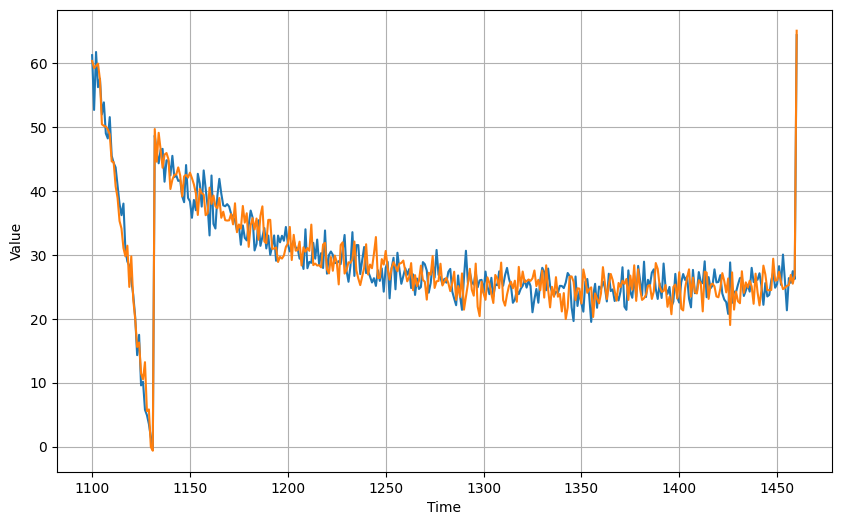

In [ ]:
### START CODE HERE

# Slice the whole SERIES to get the past values
past_series = SERIES[SPLIT_TIME-365:-365]

print(f"past series has shape: {past_series.shape}\n")


# Add the past to the moving average of diff series
diff_moving_avg_plus_past = past_series + diff_moving_avg

### END CODE HERE

print(f"moving average forecast with diff series plus past has shape: {diff_moving_avg_plus_past.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg_plus_past.shape}")

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [ ]:
# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, diff_moving_avg_plus_past)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus past forecast")

mse: 8.50, mae: 2.33 for moving average plus past forecast


Better than naive forecast, good. However the forecasts look a bit too random because we're just adding past values, which were noisy. You will use a **centered moving average** with a window size of `10` on past values to remove some of the noise. If you get stuck, you can review the lecture on centered windows and the second ungraded lab this week.

<br>
<details>
<summary><font size="2" color="darkgreen"><b>Click here for hints</b></font></summary>
    <ul>
        <li>When slicing the <code>SERIES data</code>, start from the <code>SPLIT_TIME</code> minus 370 steps
        <li>The length of <code>smooth_past_series</code> should match the length of <code>diff_moving_average</code>. If you get an operand error, it's likely that this is not being met. Try modifying the *end* index of the <code>SERIES</code> data when slicing it for <code>smooth_past_series</code>.
        <li>If you're using the ungraded lab for reference, note that that uses a window size of `11`. This assignment requires a window size of `10` so you will need to slightly modify the code accordingly.
    </ul>
</details>



smooth past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True


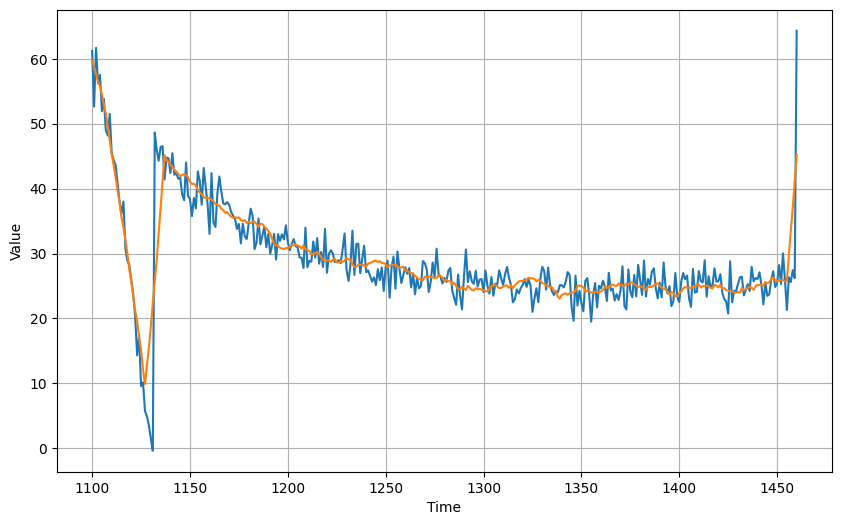

In [ ]:
### START CODE HERE

# Perform the correct split of SERIES
# Hint: When slicing the `SERIES` data, start from the `SPLIT_TIME` minus 370 steps. See the cell above for more hints.
smooth_past_series = moving_average_forecast(SERIES[SPLIT_TIME-370:-360], 10)

print(f"smooth past series has shape: {smooth_past_series.shape}\n")

# Add the smoothed out past values to the moving avg of diff series
diff_moving_avg_plus_smooth_past = smooth_past_series + diff_moving_avg

### END CODE HERE

print(f"moving average forecast with diff series plus past has shape: {diff_moving_avg_plus_smooth_past.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg_plus_smooth_past.shape}")

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [ ]:
# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, diff_moving_avg_plus_smooth_past)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus smooth past forecast")

mse: 12.53, mae: 2.20 for moving average plus smooth past forecast


**Expected Output:**

```
mse: 12.53, mae: 2.20 for moving average plus smooth past forecast
```

# Week 2: Predicting time series

Welcome! In the previous assignment you got some exposure to working with time series data, but you didn't use machine learning techniques for your forecasts. This week you will be using a deep neural network to create forecasts to see how this technique compares with the ones you already tried out. Once again all of the data is going to be generated.

Let's get started!

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Generating the data

The next cell includes a bunch of helper functions to generate and plot the time series:

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

You will be generating time series data that greatly resembles the one from last week but with some differences.

**Notice that this time all the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope as it was done in during the previous week.**

If you haven't used dataclasses before, they are just Python classes that provide a convenient syntax for storing data. You can read more about them in the [docs](https://docs.python.org/3/library/dataclasses.html).

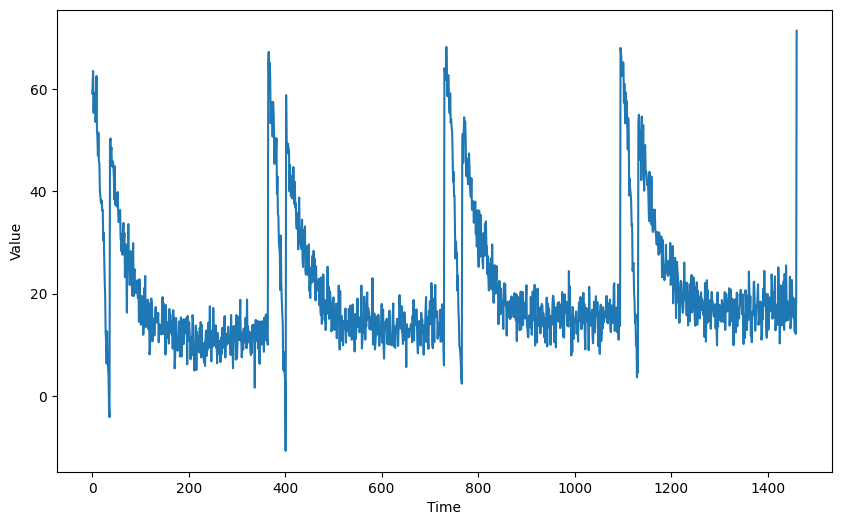

In [ ]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)

    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Splitting the data

Since you already coded the `train_val_split` function during last week's assignment, this time it is provided for you:

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

## Processing the data

As you saw on the lectures you can feed the data for training by creating a dataset with the appropiate processing steps such as `windowing`, `flattening`, `batching` and `shuffling`. To do so complete the `windowed_dataset` function below.

Notice that this function receives a `series`, `window_size`, `batch_size` and `shuffle_buffer` and the last three of these default to the "global" values defined earlier.

Be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) about `TF Datasets` if you need any help.

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):

    ### START CODE HERE

    # Create dataset from the series
    dataset = tf.data.Dataset.from_tensor_slices(G.SERIES)

    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Shuffle it
    dataset = dataset.shuffle(shuffle_buffer)

    # Split it into the features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Batch it
    dataset = dataset.batch(batch_size).prefetch(1)

    ### END CODE HERE

    return dataset

To test your function you will be using a `window_size` of 1 which means that you will use each value to predict the next one. This for 5 elements since a `batch_size` of 5 is used and no shuffle since `shuffle_buffer` is set to 1.

Given this, the batch of features should be identical to the first 5 elements of the `series_train` and the batch of labels should be equal to elements 2 through 6 of the `series_train`.

In [ ]:
# Test your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True


## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture.

Complete the `create_model` function below. Notice that this function receives the `window_size` since this will be an important parameter for the first layer of your network.

Hint:
- You will only need `Dense` layers.
- Do not include `Lambda` layers. These are not required and are incompatible with the `HDF5` format which will be used to save your model for grading.
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.

In [ ]:
def create_model(window_size=G.WINDOW_SIZE):

    ### START CODE HERE

    model = tf.keras.models.Sequential([ tf.keras.layers.Dense(50, input_shape=[window_size], activation="relu"),
                                        # tf.keras.layers.Dense(100, activation="relu"),
                                         tf.keras.layers.Dense(1)
                                       ])

    model.compile(loss="mse",
                  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

    ### END CODE HERE

    return model

In [ ]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

# Save an instance of the model
model = create_model()

# Train it
model.fit(dataset, epochs=100)

Epoch 1/100
46/46 [==============================] - 1s 9ms/step - loss: 219.0701
Epoch 2/100
46/46 [==============================] - 1s 8ms/step - loss: 68.6374
Epoch 3/100
46/46 [==============================] - 1s 9ms/step - loss: 57.8917
Epoch 4/100
46/46 [==============================] - 1s 13ms/step - loss: 51.5265
Epoch 5/100
46/46 [==============================] - 1s 8ms/step - loss: 47.9003
Epoch 6/100
46/46 [==============================] - 1s 10ms/step - loss: 46.6664
Epoch 7/100
46/46 [==============================] - 1s 6ms/step - loss: 43.1529
Epoch 8/100
46/46 [==============================] - 1s 9ms/step - loss: 41.4439
Epoch 9/100
46/46 [==============================] - 0s 4ms/step - loss: 40.5181
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 39.0531
Epoch 11/100
46/46 [==============================] - 0s 2ms/step - loss: 38.2085
Epoch 12/100
46/46 [==============================] - 0s 3ms/step - loss: 37.6455
Epoch 13/100
46/46 [==

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in the previous assignment:

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.

For this, run the cell below which uses the `generate_forecast` function to compute the forecast. This function generates the next value given a set of the previous `window_size` points for every point in the validation set.

1/1 [==============================] - 0s 40ms/step


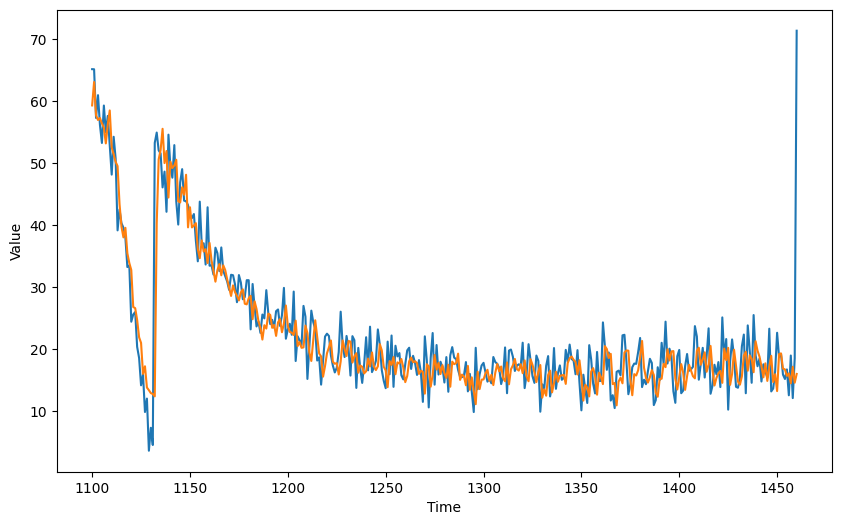

In [ ]:
def generate_forecast(series=G.SERIES, split_time=G.SPLIT_TIME, window_size=G.WINDOW_SIZE):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

    forecast = forecast[split_time-window_size:]
    results = np.array(forecast)[:, 0, 0]
    return results


# Save the forecast
dnn_forecast = generate_forecast()

# Plot it
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/forecast.png" width="500"/>
</div>

In [ ]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

**To pass this assignment your forecast should achieve an MSE of 30 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your model in a HDF5 file file which will be used for grading and after doing so, submit your assigment for grading.


- Make sure you didn't use `Lambda` layers in your model since these are incompatible with the `HDF5` format which will be used to save your model for grading.


- This environment includes a dummy `my_model.h5` file which is just a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**

In [ ]:
# Save your model in HDF5 format
model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Week 3: Using RNNs to predict time series

Welcome! In the previous assignment you used a vanilla deep neural network to create forecasts for generated time series. This time you will be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs to see how these two approaches compare.

Let's get started!

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

## Generating the data

The next cell includes a bunch of helper functions to generate and plot the time series:

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

You will be generating the same time series data as in last week's assignment.

**Notice that this time all the generation is done within a function and global variables are saved within a dataclass. This is done to avoid using global scope as it was done in during the first week of the course.**

If you haven't used dataclasses before, they are just Python classes that provide a convenient syntax for storing data. You can read more about them in the [docs](https://docs.python.org/3/library/dataclasses.html).



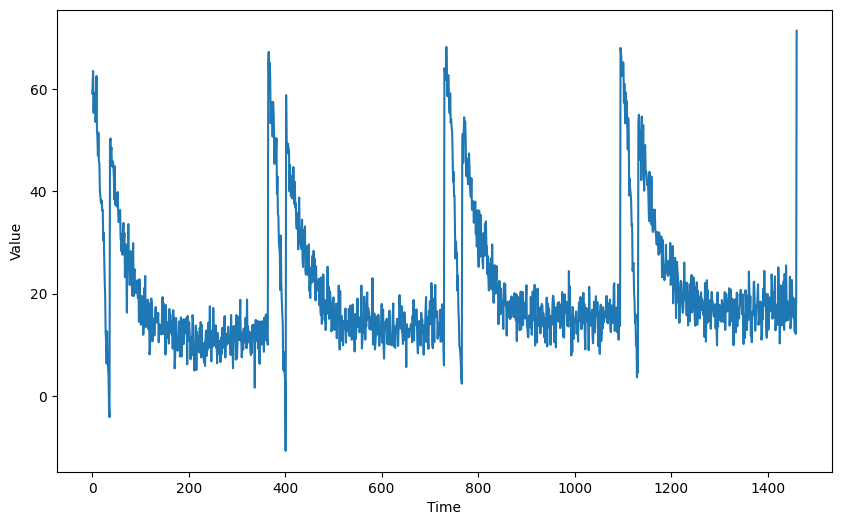

In [ ]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)

    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:



In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you layer architecture. Unlike previous weeks or courses in which you define your layers and compile the model in the same function, here you will first need to complete the `create_uncompiled_model` function below.

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:
- Fill in the `Lambda` layers at the beginning and end of the network with the correct lamda functions.
- You should use `SimpleRNN` or `Bidirectional(LSTM)` as intermediate layers.
- The last layer of the network (before the last `Lambda`) should be a `Dense` layer.

In [ ]:
def create_uncompiled_model():

    ### START CODE HERE

    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    ### END CODE HERE

    return model

In [ ]:
# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

34/34 [==============================] - 3s 12ms/step
Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate - (Optional Exercise)

As you saw in the lecture you can leverage Tensorflow's callbacks to dinamically vary the learning rate during training. This can be helpful to get a better sense of which learning rate better acommodates to the problem at hand.

**Notice that this is only changing the learning rate during the training process to give you an idea of what a reasonable learning rate is and should not be confused with selecting the best learning rate, this is known as hyperparameter optimization and it is outside the scope of this course.**

For the optimizers you can try out:
- [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)
- [`tf.keras.optimizers.SGD`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) with a momentum of 0.9

In [ ]:
def adjust_learning_rate():

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

    ### START CODE HERE

    # Select your optimizer
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)

    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    ### END CODE HERE

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 9s 31ms/step - loss: 6.8273 - mae: 7.2983 - lr: 1.0000e-06
Epoch 2/100
34/34 [==============================] - 1s 28ms/step - loss: 6.1739 - mae: 6.6460 - lr: 1.1220e-06
Epoch 3/100
34/34 [==============================] - 1s 27ms/step - loss: 5.9764 - mae: 6.4444 - lr: 1.2589e-06
Epoch 4/100
34/34 [==============================] - 1s 27ms/step - loss: 5.7571 - mae: 6.2238 - lr: 1.4125e-06
Epoch 5/100
34/34 [==============================] - 2s 47ms/step - loss: 5.5459 - mae: 6.0129 - lr: 1.5849e-06
Epoch 6/100
34/34 [==============================] - 1s 27ms/step - loss: 5.3367 - mae: 5.8036 - lr: 1.7783e-06
Epoch 7/100
34/34 [==============================] - 1s 27ms/step - loss: 5.1414 - mae: 5.6049 - lr: 1.9953e-06
Epoch 8/100
34/34 [==============================] - 1s 26ms/step - loss: 4.9941 - mae: 5.4602 - lr: 2.2387e-06
Epoch 9/100
34/34 [==============================] - 2s 49ms/step - loss: 4.8755 - mae: 5.3445 - lr: 2.5

(1e-06, 1.0, 0.0, 30.0)

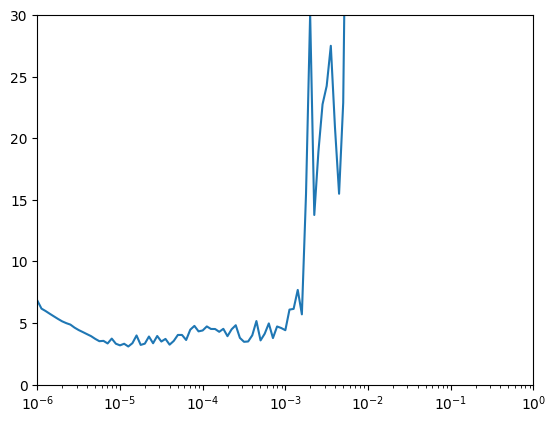

In [ ]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

## Compiling the model

Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hint:
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: `loss: nan - mae: nan` it is very likely that your network is suffering from exploding gradients. This is a common problem if you used `SGD` as optimizer and set a learning rate that is too high. **If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.**

In [ ]:
def create_model():

    tf.random.set_seed(51)

    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate=8e-5, momentum=0.9),
                  metrics=["mae"])

    ### END CODE HERE

    return model

In [ ]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 9s 29ms/step - loss: 9.5393 - mae: 10.0300
Epoch 2/50
34/34 [==============================] - 1s 27ms/step - loss: 9.4188 - mae: 9.9047
Epoch 3/50
34/34 [==============================] - 1s 28ms/step - loss: 3.6264 - mae: 4.0939
Epoch 4/50
34/34 [==============================] - 1s 27ms/step - loss: 3.8962 - mae: 4.3639
Epoch 5/50
34/34 [==============================] - 1s 27ms/step - loss: 3.1351 - mae: 3.6029
Epoch 6/50
34/34 [==============================] - 1s 27ms/step - loss: 3.2881 - mae: 3.7569
Epoch 7/50
34/34 [==============================] - 1s 28ms/step - loss: 3.1078 - mae: 3.5718
Epoch 8/50
34/34 [==============================] - 2s 46ms/step - loss: 3.1127 - mae: 3.5772
Epoch 9/50
34/34 [==============================] - 1s 36ms/step - loss: 3.2920 - mae: 3.7542
Epoch 10/50
34/34 [==============================] - 1s 27ms/step - loss: 3.1721 - mae: 3.6374
Epoch 11/50
34/34 [==============================] - 1s 28

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.

## Faster model forecasts

In the previous week you used a for loop to compute the forecasts for every point in the sequence. This approach is valid but there is a more efficient way of doing the same thing by using batches of data. The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:

- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

46/46 [==============================] - 3s 12ms/step


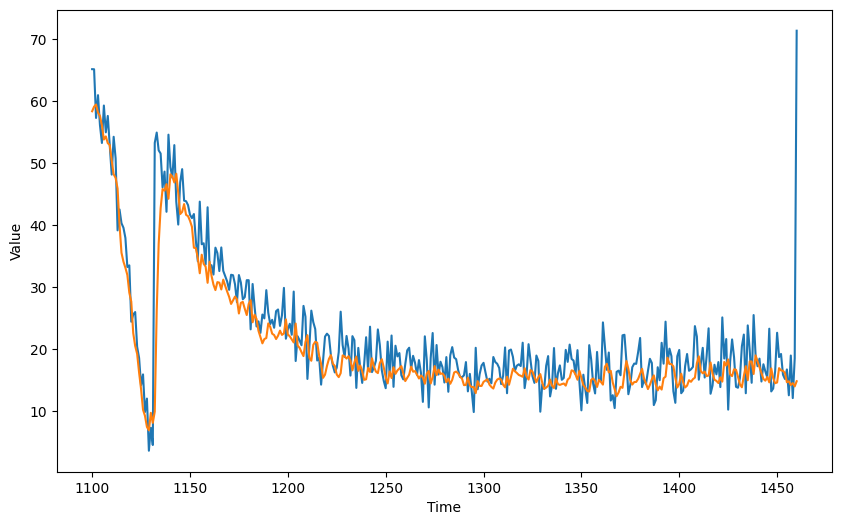

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 32.68, mae: 3.54 for forecast


**To pass this assignment your forecast should achieve an MAE of 4.5 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save your model in a `tar` file which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy `SavedModel` directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**


- Unlike last week, this time the model is saved using the `SavedModel` format. This is done because the HDF5 format does not fully support `Lambda` layers.

In [ ]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/fingerprint.pb
saved_model/my_model/assets/
saved_model/my_model/saved_model.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index


# Week 4: Using real world data

Welcome! So far you have worked exclusively with generated data. This time you will be using the [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset which contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990. In addition to be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs you will also use Convolutional layers to improve the model's performance.

Let's get started!

In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

In [ ]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

As you can see, each data point is composed of the date and the recorded minimum temperature for that date.


In the first exercise you will code a function to read the data from the csv but for now run the next cell to load a helper function to plot the time series.

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Parsing the raw data
Now you need to read the data from the csv file. To do so, complete the `parse_data_from_file` function.

A couple of things to note:

- You should omit the first line as the file contains headers.
- There is no need to save the data points as numpy arrays, regular lists is fine.
- To read from csv files use `csv.reader` by passing the appropriate arguments.
- `csv.reader` returns an iterable that returns each row in every iteration. So the temperature can be accessed via row[1] and the date can be discarded.
- The `times` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `temperatures` list.
- The values of the `temperatures` should be of `float` type. You can use Python's built-in `float` function to ensure this.

In [ ]:
def parse_data_from_file(filename):

    times = []
    temperatures = []

    with open(filename) as csvfile:

        ### START CODE HERE

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            #times.append(int(row[0]))
            temperatures.append(float(row[1]))
        times=list(range(len(temperatures)))
        ### END CODE HERE

    return times, temperatures

The next cell will use your function to compute the `times` and `temperatures` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

In [ ]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data

Since you already coded the `train_val_split` and `windowed_dataset` functions during past week's assignments, this time they are provided for you:

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define your layer architecture. Just as in last week's assignment you will do the layer definition and compilation in two separate steps. Begin by completing the `create_uncompiled_model` function below.

This is done so you can reuse your model's layers for the learning rate adjusting and the actual training.

Hint:

- `Lambda` layers are not required.
- Use a combination of `Conv1D` and `LSTM` layers followed by `Dense` layers

In [ ]:
def create_uncompiled_model():

    ### START CODE HERE

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[None, 1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        #tf.keras.layers.Dense(60, activation="relu"),
        #tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)
    ])

    ### END CODE HERE

    return model

You can test your model with the code below. If you get an error, it's likely that your model is returning a sequence. You can indeed use an LSTM with `return_sequences=True` but you have to feed it into another layer that generates a single prediction. You can review the lectures or the previous ungraded labs to see how that is done.

In [ ]:
# Test your uncompiled model

# Create an instance of the model
uncompiled_model = create_uncompiled_model()

# Get one batch of the training set(X = input, y = label)
for X, y in train_set.take(1):

    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)

# Compare the shape of the prediction and the label y (remove dimensions of size 1)
y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

## Adjusting the learning rate - (Optional Exercise)

As you saw in the lectures, you can leverage Tensorflow's callbacks to dynamically vary the learning rate before doing the actual training. This can be helpful in finding what value works best with your model. Note that this is only one way of finding the best learning rate. There are other techniques for hyperparameter optimization but it is outside the scope of this course.

For the optimizers you can try out:

- tf.keras.optimizers.Adam
- tf.keras.optimizers.SGD with a momentum of 0.9

In [ ]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    ### START CODE HERE

    # Select your optimizer
    optimizer = tf.keras.optimizers.Adam()

    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])

    ### END CODE HERE

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return history

In [ ]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

In [ ]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

## Compiling the model
Now that you have trained the model while varying the learning rate, it is time to do the actual training that will be used to forecast the time series. For this complete the `create_model` function below.

Notice that you are reusing the architecture you defined in the `create_uncompiled_model` earlier. Now you only need to compile this model using the appropriate loss, optimizer (and learning rate).

Hints:

- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.


- If after the first epoch you get an output like this: loss: nan - mae: nan it is very likely that your network is suffering from exploding gradients. This is a common problem if you used SGD as optimizer and set a learning rate that is too high. If you encounter this problem consider lowering the learning rate or using Adam with the default learning rate.

In [ ]:
def create_model():


    model = create_uncompiled_model()

    ### START CODE HERE

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=8e-4),
                  metrics=["mae"])


    ### END CODE HERE

    return model

In [ ]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in a previous assignment:

In [ ]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast.



## Faster model forecasts

In the previous week you saw a faster approach compared to using a for loop to compute the forecasts for every point in the sequence. Remember that this faster approach uses batches of data.

The code to implement this is provided in the `model_forecast` below. Notice that the code is very similar to the one in the `windowed_dataset` function with the differences that:
- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Now compute the actual forecast:

**Note:** Don't modify the cell below.

The grader uses the same slicing to get the forecast so if you change the cell below you risk having issues when submitting your model for grading.

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

**To pass this assignment your forecast should achieve a MSE of 6 or less and a MAE of 2 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture (you will need to re-run both `create_uncompiled_model` and `create_model` functions) or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save the model in the SavedModel format which will be used for grading and after doing so, submit your assigment for grading.


- This environment includes a dummy SavedModel directory which contains a dummy model trained for one epoch. **To replace this file with your actual model you need to run the next cell before submitting for grading.**

In [ ]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series leveraging a combination of Tensorflow's layers such as Convolutional and LSTMs! This resulted in a forecast that surpasses all the ones you did previously.

**By finishing this assignment you have finished the specialization! Give yourself a pat on the back!!!**